In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy
import spacy
import sklearn
import sklearn.metrics as metrics
import nltk
import string
import nltk.data
import unidecode
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from xgboost import XGBClassifier
from scipy.sparse.linalg import lobpcg
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
from french_lefff_lemmatizer.french_lefff_lemmatizer import FrenchLefffLemmatizer
from spacy_lefff import LefffLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier

from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.layers import Concatenate, Dense, Activation, Embedding, Dropout, Input, LSTM, Reshape, Lambda, RepeatVector, SpatialDropout1D
from keras import metrics as m
from keras import Model
from keras import backend as K

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


2020-04-01 11:19:25,789 - matplotlib.pyplot - DEBUG - Loaded backend module://ipykernel.pylab.backend_inline version unknown.


<a id='home'></a>
## Table of contents
[Import des données](#0)<br>

1. [Exploration de données](#1)<br>
    1.1. [Description de la variable à prédire](#11)<br>
    1.2. [Description des variables explicatives](#12)<br>
2. [Feature engineering](#2)<br> 
3. [Tests de différents modèles de machine learning](#3)<br> 
    3.1. [Régression logistique](#31)<br>
    3.2. [Random forest](#32)<br>
    3.3. [XGBoost](#33)<br>
4. [Test du Deep Learning avec Keras](#4)<br> 
5. [Synthèse et pistes d'amélioration](#5)<br> 
6. [Préparation du test set et prédictions](#6)<br> 

<a id='0'></a>
## Import des données
<a href='#home'>Back home</a>

In [2]:
train = pd.read_csv('train.csv', sep=';')
train.head(2)

,ID,review_content,review_title,review_stars,product,Target
0,0,En appelant un acheteur pour demander si l'écr...,La Police s'inscrit en acheteur privé sur Pric...,5,2fbb619e3606f9b7c213e858a109cda771aa2c47ce50d5...,0
1,1,"Alors, là, on a affaire au plus grand Navet ja...",Chef D'Oeuvre Absolu en vue...,5,7b56d9d378d9e999d293f301ac43d044cd7b4786d09afb...,1


In [3]:
test = pd.read_csv('test.csv', sep=';')
test.shape

(20000, 5)

<a id='1'></a>
### 1. Exploration de données
<a href='#home'>Back home</a>

<a id='11'></a>
#### 1.1.  Description de la variable à prédire

(-1.1119828858422338,
 1.1273453655926944,
 -1.1095787588427655,
 1.100456131373465)

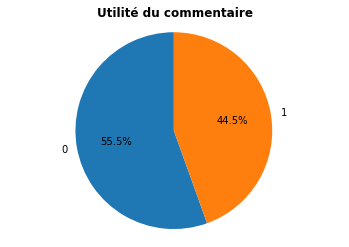

In [65]:
fig, ax = plt.subplots()
ax.pie(train.Target.value_counts(), labels=train.Target.unique(),shadow=False,autopct='%1.1f%%', startangle=90)
plt.title("Utilité du commentaire", fontweight="bold")
ax.axis('equal')

**Commentaire**

Avec une répartition 55.5%/44.5%, on considère que les données sont équilibrées. 

<a id='12'></a>
#### 1.2.  Description des variables explicatives

In [5]:
train.describe()

,ID,review_stars,Target
count,60000.000000,60000.000000,60000.000000
mean,29999.500000,4.308667,0.554850
std,17320.652413,1.151512,0.496987
min,0.000000,1.000000,0.000000
25%,14999.750000,4.000000,0.000000
50%,29999.500000,5.000000,1.000000
75%,44999.250000,5.000000,1.000000
max,59999.000000,5.000000,1.000000


In [6]:
print("Nombre de reviews uniques : {}".format(train['ID'].nunique()))

Nombre de reviews uniques : 60000


In [7]:
print('Nombre de valeurs manquantes parmi les {} échantillons de train : '.format(train.shape[0]))
print("ID : {}".format(train.ID.isna().sum()))
print("review_content : {}".format(train.review_content.isna().sum()))
print("review_title : {}".format(train.review_title.isna().sum()))
print("review_stars : {}".format(train.review_stars.isna().sum()))
print("product : {}".format(train['product'].isna().sum()))
print("Target : {}".format(train.Target.isna().sum()))

Nombre de valeurs manquantes parmi les 60000 échantillons de train : 
ID : 0
review_content : 0
review_title : 3
review_stars : 0
product : 0
Target : 0


In [8]:
print('Nombre de valeurs manquantes parmi les {} échantillons de test: '.format(test.shape[0]))
print("ID : {}".format(test.ID.isna().sum()))
print("review_content : {}".format(test.review_content.isna().sum()))
print("review_title : {}".format(test.review_title.isna().sum()))
print("review_stars : {}".format(test.review_stars.isna().sum()))
print("product : {}".format(test['product'].isna().sum()))

Nombre de valeurs manquantes parmi les 20000 échantillons de test: 
ID : 0
review_content : 0
review_title : 0
review_stars : 0
product : 0


**Commentaire**

Il manque seulement 3 titres de reviews dans l'échantillon de train. Ceci n'est pas significatif pour la prédiction.
On remplrira les valeurs manquantes dans la phase de feature engineering.

- **Exploration de la feature 'product'**

In [9]:
#Nombre de produits uniques
print("Nombre de produits uniques : {}".format(train['product'].nunique()))

Nombre de produits uniques : 46293


In [10]:
df_product = pd.DataFrame(train.groupby('product').ID.count())
df_product.reset_index(inplace=True)
df_product.describe()

,ID
count,46293.000000
mean,1.296092
std,1.482541
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,135.000000


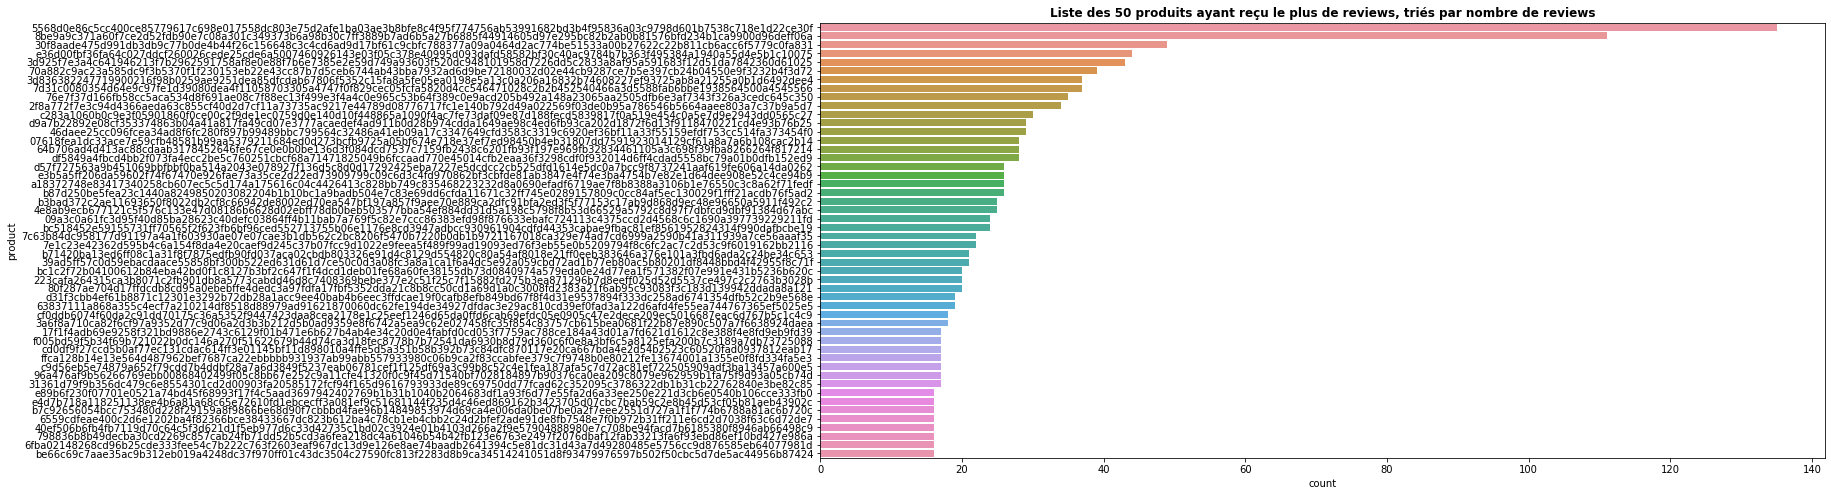

In [11]:
plt.figure(figsize=(18, 8))
plt.title("Liste des 50 produits ayant reçu le plus de reviews, triés par nombre de reviews",fontweight='bold')
sns.countplot(y=train['product'], order=train['product'].value_counts()[:50].index)
plt.show()

In [12]:
df_product[df_product.ID > 50]['product']

15520    5568d0e86c5cc400ce85779617c698e017558dc803e75d...
25346    8be9a9c371a60f7ce2d52fdb90e7c08a301c349373b6a9...
Name: product, dtype: object

In [13]:
# Note moyenne par produit
pd.DataFrame(train.groupby('product').review_stars.mean()).describe()

,review_stars
count,46293.000000
mean,4.335129
std,1.072597
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


**Commentaire**

Dans l'échantillon : 
- chaque produit reçoit en moyenne 1.3 reviews
- 75% des produits reçoivent 1 seule review
- pour un produit, le maximum de reviews reçues est 135
- deux produits ont reçu particulèrement plus de reviews que les autres 

- **Exploration de la feature 'review_stars'**

In [14]:
train.review_stars.describe()

count    60000.000000
mean         4.308667
std          1.151512
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: review_stars, dtype: float64

Text(0.5, 0, "Nombre d'étoiles")

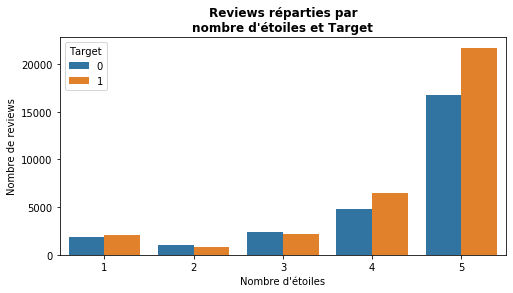

In [15]:
plt.figure(figsize=(8, 4))
sns.countplot(x="review_stars", hue="Target", data=train)
plt.title("Reviews réparties par\nnombre d'étoiles et Target", fontweight="bold", fontsize=12)
plt.ylabel("Nombre de reviews")
plt.xlabel("Nombre d'étoiles")

In [16]:
train[train.Target == 0].review_stars.describe()

count    26709.000000
mean         4.258565
std          1.186110
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: review_stars, dtype: float64

In [17]:
train[train.Target == 1].review_stars.describe()

count    33291.000000
mean         4.348863
std          1.121385
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: review_stars, dtype: float64

**Commentaire**

- La note moyenne d'une review est 4.3
- La meilleure note est 5 et la moins bonne est 1
- 50% des notes valent 5
- Selon le nombre d'étoiles, la distribution des reviews par Target 0/1 n'est pas la même. La feature "review_stars" peut jouer dans la prédiction.

- **Exploration de la feature 'review_title'**

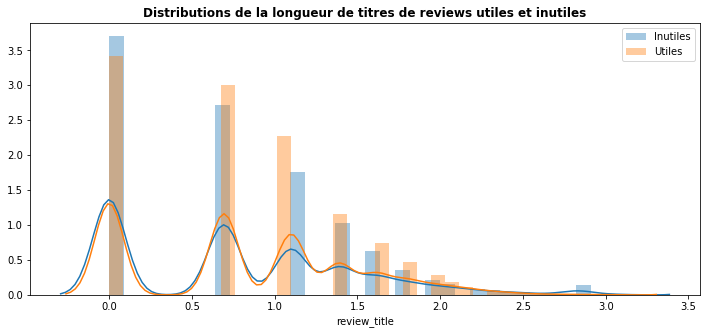

In [18]:
plt.figure(figsize=(12, 5))
sns.distplot(np.log(train[train.Target == 0]['review_title'].dropna().apply(lambda x: len(x.split()))), label='Inutiles')
sns.distplot(np.log(train[train.Target == 1]['review_title'].dropna().apply(lambda x: len(x.split()))), label='Utiles')
plt.legend()
plt.title("Distributions de la longueur de titres de reviews utiles et inutiles", fontweight="bold", fontsize=12)
plt.show()

**Commentaire**

- Il apparaît qu'un titre court est plus souvent associé à une review inutile qu'un titre un peu plus long.
- Cette caractéristiques est à garder à l'esprit lors de la prédiction : une feature longueur de titre pourrait être ajoutée au modèle


*Mots les plus représentés dans les titres*

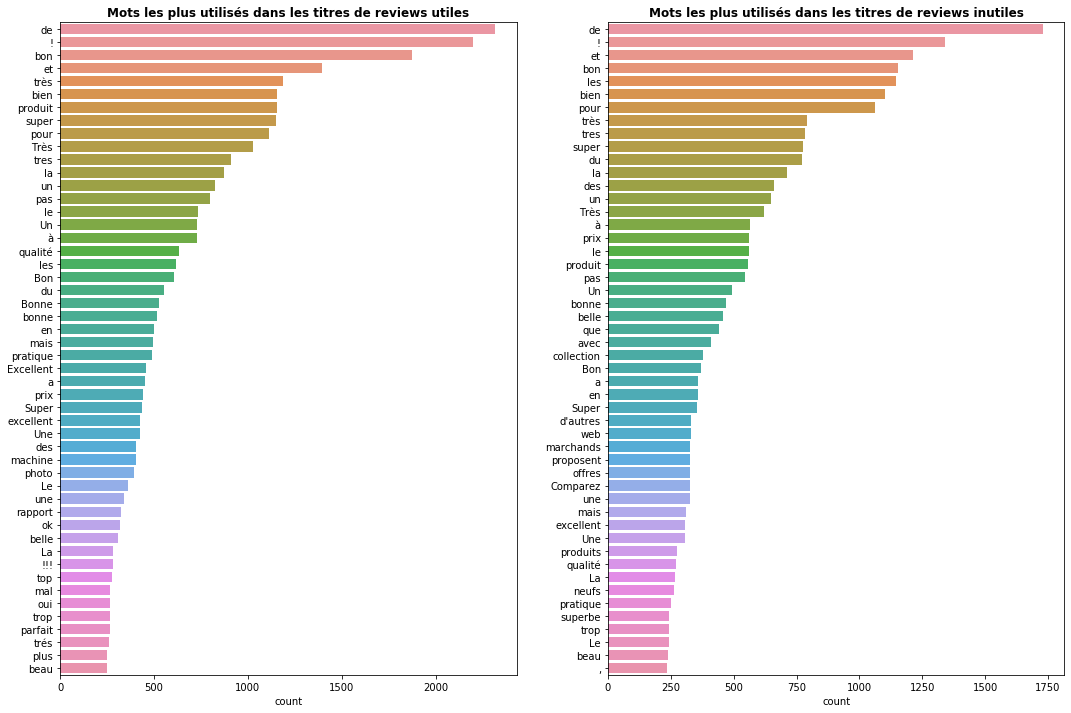

In [19]:
plt.figure(figsize=(18,12))
plt.subplot(121)
plt.title('Mots les plus utilisés dans les titres de reviews utiles', fontweight="bold", fontsize=12)
sns.countplot(y=train[train.Target == 1]['review_title'].str.split(expand=True).unstack(),
             order=train[train.Target == 1]['review_title'].str.split(expand=True).unstack().value_counts()[:50].index)
plt.subplot(122)
plt.title('Mots les plus utilisés dans les titres de reviews inutiles', fontweight="bold", fontsize=12)
sns.countplot(y=train[train.Target == 0]['review_title'].str.split(expand=True).unstack(),
             order=train[train.Target == 0]['review_title'].str.split(expand=True).unstack().value_counts()[:50].index)
plt.show()

**Commentaire**

Les mots les plus utilisés dans le titre des reviews semblent être les mêmes pour les reviews utiles et inutiles. Néanmoins, à ce stade, les mots les plus courants ne sont pas porteurs d'information. Il va falloir procéder à un nettoyage des données afin de supprimer tous ces mots très présents mais non porteur de sens.

- **Exploration de la feature 'review_content'**


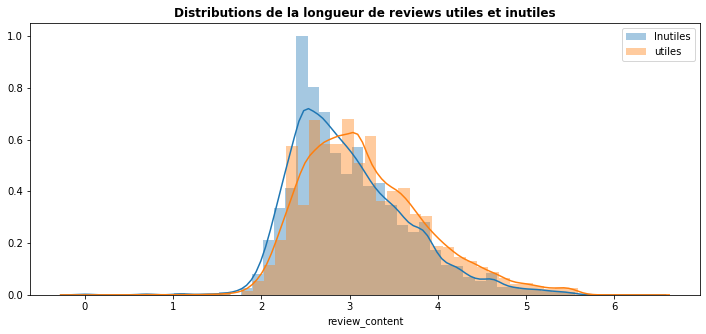

In [20]:
plt.figure(figsize=(12, 5))
sns.distplot(np.log(train[train.Target == 0]['review_content'].apply(lambda x: len(x.split()))), label='Inutiles')
sns.distplot(np.log(train[train.Target == 1]['review_content'].apply(lambda x: len(x.split()))), label='utiles')
plt.legend()
plt.title("Distributions de la longueur de reviews utiles et inutiles", fontweight="bold", fontsize=12)
plt.show()

**Commentaire**
- les reviews utiles semblent être légèrement plus longues que les reviews labelisées inutiles
- une feature pourra être ajoutée dans le modèle de prédiction prenant la valeur de la longueur de la review

*Mots les plus représentés sans les reviews*

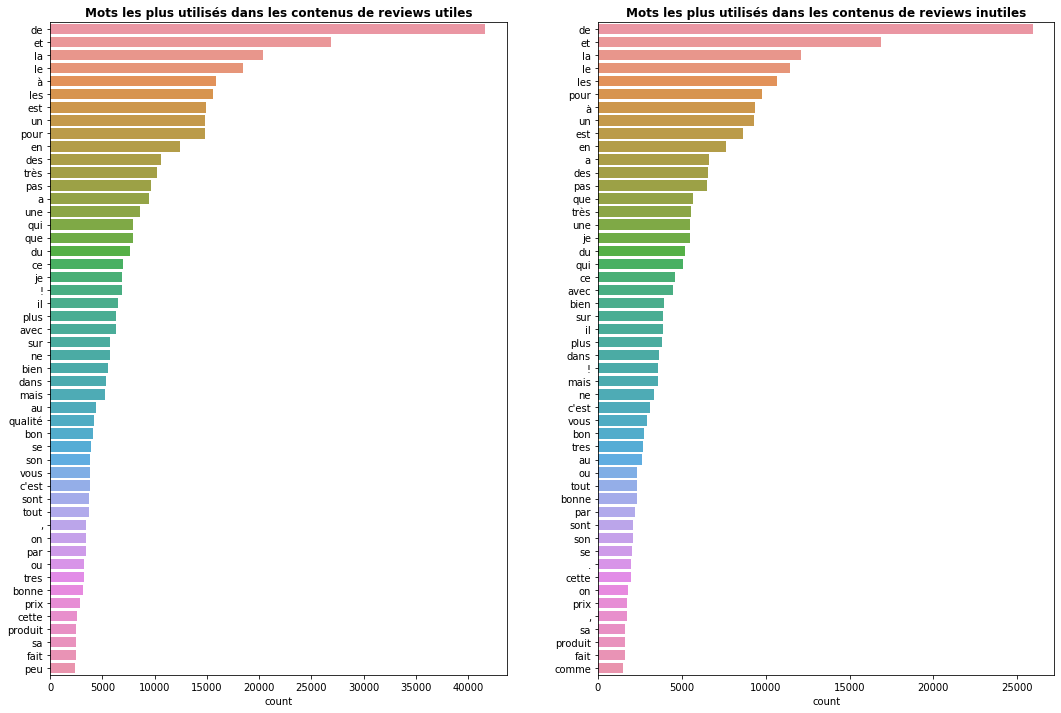

In [21]:
plt.figure(figsize=(18,12))
plt.subplot(121)
plt.title('Mots les plus utilisés dans les contenus de reviews utiles', fontweight="bold", fontsize=12)
sns.countplot(y=train[train.Target == 1]['review_content'].str.split(expand=True).unstack(),
             order=train[train.Target == 1]['review_content'].str.split(expand=True).unstack().value_counts()[:50].index)
plt.subplot(122)
plt.title('Mots les plus utilisés dans les contenus de reviews inutiles', fontweight="bold", fontsize=12)
sns.countplot(y=train[train.Target == 0]['review_content'].str.split(expand=True).unstack(),
             order=train[train.Target == 0]['review_content'].str.split(expand=True).unstack().value_counts()[:50].index)
plt.show()

**Commentaire**

Comme pour le titre, les mots les plus utilisés dans le contenu des reviews semblent être les mêmes pour les reviews utiles et inutiles. Néanmoins, à ce stade, les mots les plus courants ne sont pas porteurs d'information. Il va falloir procéder à un nettoyage des données afin de supprimer tous ces mots très présents mais non porteur de sens.

<a id='2'></a>
### 2. Feature engineering
<a href='#home'>Back home</a>

Dans cette partie, les titres et le contenu des reviews vont être nettoyés (suppression d'accents, de ponctuation, des stopwords, etc.) afin de pouvoir tirer le maximum d'information pour la prédiction.
Une fois les textes nettoyés, ils pourront être réorganisés selon la méthode TFIDF.

On a également vu que la longueur de la review pouvait avoir une influence sur la Target : cette feature va être créée et ajoutée au dataframe.
Il en est de même pour la longueur du titre.

Aussi, la distribution des Targets diffère selon le nombre d'étoiles : cette feature va être catégorisée et intégrée aux variables de prédiction.

**Nettoyage des données et création de nouvelles features**

In [54]:
# Déclaration des stopwords
french_stopwords_unaccented = []
for w in stopwords.words('french'):
    french_stopwords_unaccented.append(unidecode.unidecode(w)) 
    
tokenizer = nltk.RegexpTokenizer(r"\w+")#pattern = r'[^a-zA-Z0-9\s]'

# Déclaration du Lemmatizer en français
#lemmatizer = FrenchLefffLemmatizer()
nlp = spacy.load('fr')
french_lemmatizer = LefffLemmatizer()
nlp.add_pipe(french_lemmatizer, name='lefff')

def french_lemm(x):
    doc = nlp(x)
    chaine = ""
    for d in doc:
        chaine = chaine + ' ' + d.lemma_
    return chaine

# Fonction qui filtre les stopwords, met en minuscule, et supprime la ponctuation
def preprocess(text):
    text_lower = text.lower()
    text_unaccented = unidecode.unidecode(text_lower)
    text_unaccented.translate(string.punctuation)
    text_tokens = tokenizer.tokenize(text_unaccented)
    tokens_without_sw = [word for word in text_tokens if not word in french_stopwords_unaccented]
    return tokens_without_sw

# fonction qui transforme une liste en string
def strg(x):
    return (" ".join(x))

# Fonction qui centralise tous les retraitements
def feature_engineering(X):
    # Fill NA
    X.review_title.fillna('no_title', inplace=True)
    X.review_content.fillna('no_content', inplace=True)
    
    # Application de la fonction preprocess
    X['review_content_preprocessed'] = X.review_content.apply(lambda x: preprocess(x)).apply(lambda x: strg(x))
    X['review_title_preprocessed'] = X.review_title.apply(lambda x: preprocess(x)).apply(lambda x: strg(x))
    
    # Lemmatisation
    X['review_content_lemm'] = X.review_content_preprocessed.apply(lambda x: french_lemm(x))
    X['review_title_lemm'] = X.review_title_preprocessed.apply(lambda x: french_lemm(x))
    
    # Création de la feature longueur de la review
    X['review_content_len'] = X['review_content'].apply(lambda x: len(x.split()))
    
    # Création de la feature longueur du titre
    X['review_title_len'] = X['review_title'].apply(lambda x: len(x.split()))
    
    return X

2020-04-01 12:07:36,804 - spacy_lefff.lefff - INFO - New LefffLemmatizer instantiated.
2020-04-01 12:07:36,805 - spacy_lefff.lefff - INFO - Token lefff_lemma already registered
2020-04-01 12:07:36,807 - spacy_lefff.lefff - INFO - Reading lefff data...
2020-04-01 12:07:37,340 - spacy_lefff.lefff - INFO - Successfully loaded lefff lemmatizer


In [55]:
train_cleaned = feature_engineering(train)

Après nettoyage, les mots sont revisualiés, triés par occurrence. Comme prévu, les mots stopwords ne sont plus inclus. Les mots les plus présents restent les mêmes dans le titre et dans le contenu, que la review soit notée utile ou non. Les différences apparaissent dans les mots moins présentés. Ce sont ces mots là qui porte l'information, il faudra alors tacher de les inclure dans notre modèle. Pour cela, on va choisir la méthode TFIDF de représebtation des mots.

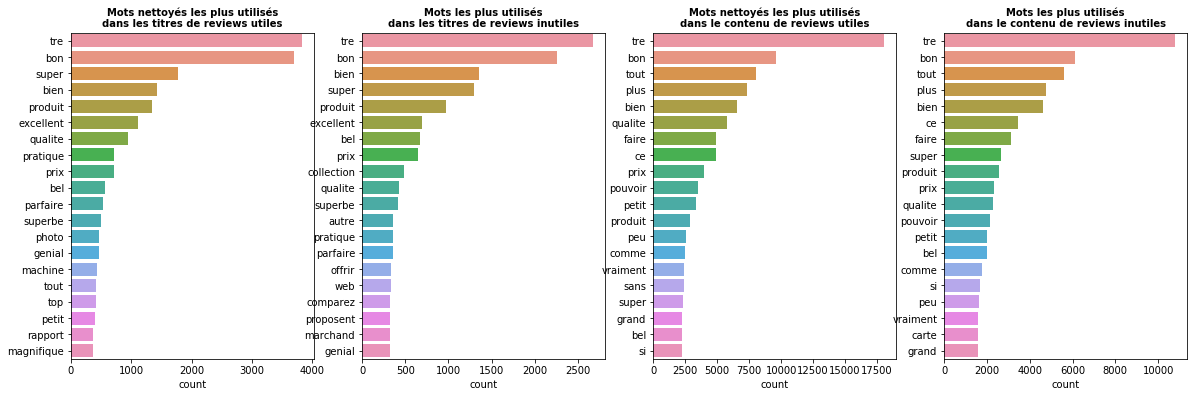

In [51]:
plt.figure(figsize=(20,6))
plt.subplot(141)
plt.title('Mots nettoyés les plus utilisés\ndans les titres de reviews utiles', fontweight="bold", fontsize=10)
sns.countplot(y=train_cleaned[train_cleaned.Target == 1]['review_title_lemm'].str.split(expand=True).unstack(),
             order=train_cleaned[train_cleaned.Target == 1]['review_title_lemm'].str.split(expand=True).unstack().value_counts()[:20].index)
plt.subplot(142)
plt.title('Mots les plus utilisés\ndans les titres de reviews inutiles', fontweight="bold", fontsize=10)
sns.countplot(y=train_cleaned[train_cleaned.Target == 0]['review_title_lemm'].str.split(expand=True).unstack(),
             order=train_cleaned[train_cleaned.Target == 0]['review_title_lemm'].str.split(expand=True).unstack().value_counts()[:20].index)
plt.subplot(143)
plt.title('Mots nettoyés les plus utilisés\ndans le contenu de reviews utiles', fontweight="bold", fontsize=10)
sns.countplot(y=train_cleaned[train_cleaned.Target == 1]['review_content_lemm'].str.split(expand=True).unstack(),
             order=train_cleaned[train_cleaned.Target == 1]['review_content_lemm'].str.split(expand=True).unstack().value_counts()[:20].index)
plt.subplot(144)
plt.title('Mots les plus utilisés\ndans le contenu de reviews inutiles', fontweight="bold", fontsize=10)
sns.countplot(y=train_cleaned[train_cleaned.Target == 0]['review_content_lemm'].str.split(expand=True).unstack(),
             order=train_cleaned[train_cleaned.Target == 0]['review_content_lemm'].str.split(expand=True).unstack().value_counts()[:20].index)
plt.show()

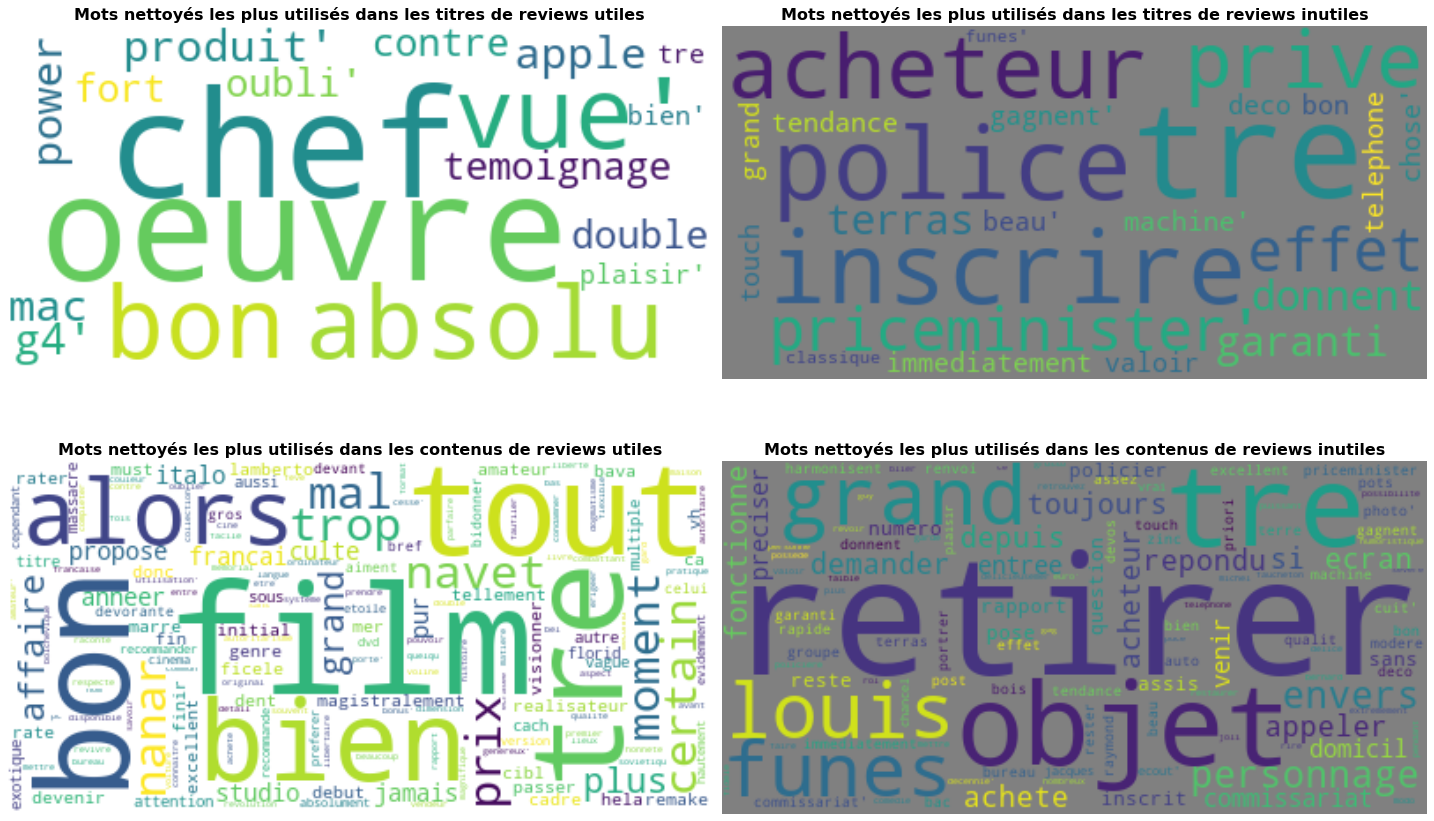

In [50]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize = (20, 15))
ax1.set_title('Mots nettoyés les plus utilisés dans les titres de reviews utiles',fontweight="bold", size=16)
wordcloud_usefull = WordCloud(background_color = 'white').generate(str(train_cleaned[train_cleaned.Target == 1].review_title_lemm.values))
ax1.imshow(wordcloud_usefull, interpolation = 'bilinear')
ax1.axis('off')
plt.tight_layout(pad=1)
ax2.set_title('Mots nettoyés les plus utilisés dans les titres de reviews inutiles',fontweight="bold", size=16)
wordcloud_useless = WordCloud(background_color = 'grey').generate(str(train_cleaned[train_cleaned.Target == 0].review_title_lemm.values))
ax2.imshow(wordcloud_useless, interpolation = 'bilinear')
ax2.axis('off')
plt.tight_layout(pad=1)
ax3.set_title('Mots nettoyés les plus utilisés dans les contenus de reviews utiles',fontweight="bold", size=16)
wordcloud_usefull = WordCloud(background_color = 'white').generate(str(train_cleaned[train_cleaned.Target == 1].review_content_lemm.values))
ax3.imshow(wordcloud_usefull, interpolation = 'bilinear')
ax3.axis('off')
plt.tight_layout(pad=1)
ax4.set_title('Mots nettoyés les plus utilisés dans les contenus de reviews inutiles', fontweight="bold",size=16)
wordcloud_useless = WordCloud(background_color = 'grey').generate(str(train_cleaned[train_cleaned.Target == 0].review_content_lemm.values))
ax4.imshow(wordcloud_useless, interpolation = 'bilinear')
ax4.axis('off')
plt.tight_layout(pad=1)
plt.show()

***TFIDF : titre de la review***

In [28]:
word_count_title = pd.DataFrame(train_cleaned[train_cleaned.Target == 1]['review_title_lemm'].str.split(expand=True).unstack().value_counts())
print("Taille du vocabulaire des titres : {} mots".format(word_count_title.shape[0]))

Taille du vocabulaire des titres : 11502 mots


In [29]:
#A des fins de prédiction, on filtre les mots qui apparaissent trop souvent dans le corpus, et qui de ce fait, 
#n'apportent pas beaucoup d'information à la prédiction. 
#Aussi, on pose un nombre max de mots dans un but de performance.
tfidf_title_vec=TfidfVectorizer(min_df=10,max_features=200)
tfidf_title=tfidf_title_vec.fit_transform(train_cleaned['review_title_lemm'])
train_tfidf_title = pd.DataFrame(tfidf_title.todense())
train_tfidf_title = train_tfidf_title.add_prefix('title_')
train_tfidf_title.shape

(60000, 200)

***TFIDF : contenu de la review***

In [30]:
word_count_content = pd.DataFrame(train_cleaned[train_cleaned.Target == 1]['review_content_lemm'].str.split(expand=True).unstack().value_counts())
print("Taille du vocabulaire des reviews : {} mots".format(word_count_content.shape[0]))

Taille du vocabulaire des reviews : 42549 mots


In [31]:
tfidf_content_vec=TfidfVectorizer(min_df=10, max_features=5000)
tfidf_content=tfidf_content_vec.fit_transform(train_cleaned['review_content_lemm'])
train_tfidf_content = pd.DataFrame(tfidf_content.todense())
train_tfidf_content = train_tfidf_content.add_prefix('cont_')
train_tfidf_content.shape

(60000, 5000)

***Encoding de review_stars***

In [32]:
train_dummy_stars = pd.get_dummies(train_cleaned.review_stars, prefix='stars')
train_dummy_stars.head(2)

,stars_1,stars_2,stars_3,stars_4,stars_5
0,0,0,0,0,1
1,0,0,0,0,1


***Concaténation des dataframes TFIDF du contenu, TFIDF du titre, review_stars***

A noter : après avoir testé des modèles avec les longueurs de titres et de contenus, ces deux features ne sont pas inclus dans les modèles présentés. En effet, les informations de longueurs n'ont pas apporté plus d'information que les données textuelles.

In [33]:
concat1 = pd.concat([train_tfidf_content,train_tfidf_title], axis=1)
train_engineered = pd.concat([concat1,train_dummy_stars], axis=1)
train_engineered.shape

(60000, 5205)

***Préparation des jeux de train, validation et test***

In [34]:
X_train, X_test, y_train, y_test = train_test_split(train_engineered,train.Target,test_size=0.3,random_state=0)

<a id='3'></a>
### 3. Tests de modèles de machine learning
<a href='#home'>Back home</a>

Trois modèles sont testés dans cette partie :
- regression logistique
- random forest
- XGBoost

Les modèles sont évalués via le score ROC AUC.

In [35]:
# Fonction qui dessine la ROC curve et donne l'aire sous la courbe.
def plot_roc_curve(model, xtest, ytest):
    probs = model.predict_proba(xtest)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(ytest, preds)
    roc_auc = metrics.auc(fpr, tpr)
    
    plt.figure(figsize=(6,4))
    plt.title('Courbe ROC')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

<a id='31'></a>
#### 3.1. Régression logistique

In [36]:
lr = LogisticRegression(random_state=0,solver='lbfgs')
lr.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

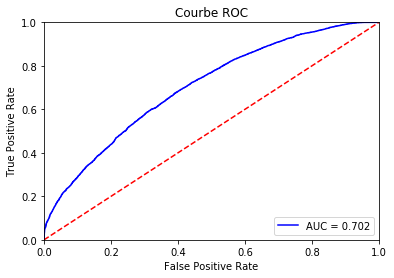

In [64]:
plot_roc_curve(lr, X_test, y_test)

<a id='32'></a>
#### 3.2. Random forest

In [38]:
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

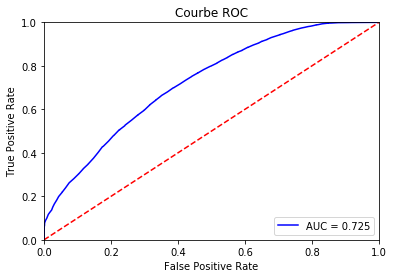

In [39]:
plot_roc_curve(rf, X_test, y_test)

<a id='33'></a>
#### 3.2. XGBoost

In [40]:
xgbc = XGBClassifier(random_state=0)
xgbc.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

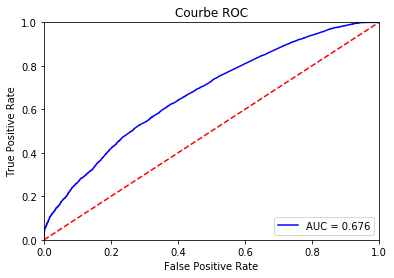

In [41]:
plot_roc_curve(xgbc, X_test, y_test)

**Commentaire**

A ce stade, en prenant le score ROC AUC comme métrique, le meilleur modèle semble être la combinaison TFIDF+random forest. 
Les hyperparamètres n'ont pas été travaillés à ce stade.

<a id='4'></a>
### 4. Test du Deep Learning avec Keras
<a href='#home'>Back home</a>

Dans cette partie, un nouveau modèle va être testé, qui s'appuie notamment sur les réseaux de neurones récurrents.

Les données en entrée vont être les mêmes que celles utlisées pour les modèles précédents, afin de comparer les performances de modèles : "review_content_lemm", "review_title_lemm" et "review_stars", afin de prédire la Target.

Les données textuelles ont connu le même nettoyage.
En revanche, contrairement aux autres modèles, les données textuelles ne vont pas être représentées via TFIDF, mais on va utiliser une couche d'embedding de keras.

#### 3.1. Préparation des datasets de train et test

In [42]:
Y2 = train['Target']
X2 = train[['review_content_lemm','review_title_lemm','review_stars']]
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2,Y2, test_size = 0.2, random_state = 0)
print(X2_train.shape,Y2_train.shape)
print(X2_test.shape,Y2_test.shape)

(48000, 3) (48000,)
(12000, 3) (12000,)


In [43]:
# Tokenisation de review_content_lemm
max_fatures1 = 5000
tokenizer = Tokenizer(num_words=max_fatures1, split=' ')
tokenizer.fit_on_texts(X2_train['review_content_lemm'].values)

X_train_content = tokenizer.texts_to_sequences(X2_train['review_content_lemm'].values)
X_train_content = pad_sequences(X_train_content)

X_test_content = tokenizer.texts_to_sequences(X2_test['review_content_lemm'].values)
X_test_content = pad_sequences(X_test_content,maxlen=X_train_content.shape[1])

In [44]:
# Tokenisation de review_title_lemm
max_fatures2 = 200
tokenizer = Tokenizer(num_words=max_fatures2, split=' ')
tokenizer.fit_on_texts(X2_train['review_title_lemm'].values)

X_train_title = tokenizer.texts_to_sequences(X2_train['review_title_lemm'].values)
X_train_title = pad_sequences(X_train_title)

X_test_title = tokenizer.texts_to_sequences(X2_test['review_title_lemm'].values)
X_test_title = pad_sequences(X_test_title,maxlen=X_train_title.shape[1])

In [45]:
# One Hot Encoding de review_stars
X_train_stars = pd.get_dummies(X2_train.review_stars, prefix='stars').values
X_test_stars = pd.get_dummies(X2_test.review_stars, prefix='stars').values

#### 3.2. Déclaration du réseau de neurones

Dans un premier temps, on choisit un nombre restreint de couches. Des travaux complémentaires pourraient amener à ajouter des couches pour améliorer les performances.

In [46]:
# Input 1 : review content
input1 = Input(shape=(X_train_content.shape[1],))
embedding_layer1 = Embedding(max_fatures1, 32,input_length = X_train_content.shape[1])(input1)
lstm_layer1 = LSTM(100, dropout=0.2, recurrent_dropout=0.2)(embedding_layer1)

# Input 2 : review title
input2 = Input(shape=(X_train_title.shape[1],))
embedding_layer2 = Embedding(max_fatures2, 32,input_length = X_train_title.shape[1])(input2)
lstm_layer2 = LSTM(100, dropout=0.2, recurrent_dropout=0.2)(embedding_layer2)

# Input 3 : review stars
input3 = Input(shape=(X_train_stars.shape[1],))
dense_layer1 = Dense(10,activation='relu')(input3)

concat_layer = Concatenate()([lstm_layer1, lstm_layer2, dense_layer1])
output = Dense(1, activation='sigmoid')(concat_layer)

model = Model(inputs=[input1, input2, input3], outputs=output)

model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics=[m.AUC()])
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 230)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 16)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 230, 32)      160000      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 16, 32)       6400        input_2[0][0]                    
____________________________________________________________________________________________

#### 3.3. Entraînement du réseau

In [47]:
model.fit(x=[X_train_content,X_train_title,X_train_stars], 
          y=Y2_train, 
          epochs=3, 
          batch_size=32, 
          validation_data=([X_test_content,X_test_title,X_test_stars], Y2_test))

Train on 48000 samples, validate on 12000 samples
Epoch 1/3
48000/48000 [==============================] - 206s 4ms/step - loss: 0.6253 - auc_1: 0.6867 - val_loss: 0.6076 - val_auc_1: 0.7090
Epoch 2/3
48000/48000 [==============================] - 202s 4ms/step - loss: 0.5794 - auc_1: 0.7501 - val_loss: 0.6080 - val_auc_1: 0.7083
Epoch 3/3
48000/48000 [==============================] - 201s 4ms/step - loss: 0.5486 - auc_1: 0.7835 - val_loss: 0.6163 - val_auc_1: 0.7024


#### 3.4. Evaluation du modèle

In [48]:
print("Score ROC AUC pour le modèle RNN : %0.3f" %model.evaluate(x=[X_test_content, X_test_title,X_test_stars], y=Y2_test)[1])

12000/12000 [==============================] - 10s 857us/step
Score ROC AUC pour le modèle RNN : 0.702


<a id='5'></a>
### 5. Synthèse et pistes d'amélioration
<a href='#home'>Back home</a>

Parmi les modèles testés, le modèle TFIDF + Random Forest apparaît comme le plus performant, avec un score ROC AUC = 72%.

Afin d'améliorer la performance de ce modèle, ainsi que des autres modèles testés, les pistes d'amélioration suivantes peuvent être étudiées : 
- tester d'autres algorithmes
- travailler l'hyperparamétrage des modèles
- approfondir le nettoyage des données
- tester d'autres méthodes de feature extraction et de représentation des données textuelles

Egalement, un pipeline pourrait être mis en place dans un contexte d'industrialisation.

<a id='6'></a>
### 6. Préparation du test set et prédictions
<a href='#home'>Back home</a>

#### 6.1. Préparation du test set 

In [56]:
test_cleaned = feature_engineering(test)

In [57]:
test_tfidf_title = tfidf_title_vec.transform(test['review_title_lemm'])
test_tfidf_title = pd.DataFrame(test_tfidf_title.todense())

In [58]:
test_tfidf_content = tfidf_content_vec.transform(test['review_content_lemm'])
test_tfidf_content = pd.DataFrame(test_tfidf_content.todense())

In [59]:
test_dummy_stars = pd.get_dummies(test.review_stars, prefix='stars')

In [60]:
concat2 = pd.concat([test_tfidf_content,test_tfidf_title], axis=1)
test_engineered = pd.concat([concat2,test_dummy_stars], axis=1)
test_engineered.shape

(20000, 5205)

#### 6.2. Prédictions

In [61]:
predictions_proba = rf.predict_proba(test_engineered)

In [62]:
predictions_proba_df = pd.DataFrame(predictions_proba).reset_index().rename(columns={'index':'ID', 1:'Target'}).drop(0, axis=1)
predictions_proba_df.head(5)

,ID,Target
0,0,0.79000
1,1,0.01148
2,2,0.00000
3,3,0.35000
4,4,0.62000


In [63]:
predictions_proba_df.to_csv('leveugle_submission.csv', sep=';', index=False)